# Supplementary material for the manuscript entitled "$A2G^2$: A Python wrapper to perform very large alignments"


**Jose Sergio Hleap<sup>1,2,4,*</sup>, Melania E. Cristescu<sup>2</sup>, and Dirk Steinke<sup>3</sup>**

<sup>1</sup> SHARCNET, University of Guelph, Guelph, N1G1Y4, Canada

<sup>2</sup> Department of Biology, McGill University, Montreal, H3A 1B1, Canada

<sup>3</sup> Centre for Biodiversity Genomics (CBG), University of Guelph, Guelph, N1G2W1, Canada.

<sup>4</sup> SQUALUS Foundation, Cali, 76001, Colombia.

<sup>*</sup> Corresponding author: jshleap@sharcnet.ca



In the main manuscript we describe the $A2G^2$ algorithm, which uses a two anchor approach to align amplicon-like sequences for protein coding genes. We argue that our method can align a high number of sequences in a reasonable time, that scales with the number of CPUs used. Here we test and compare our method against both MAFFT and the PASTA algorithm. The contents of this notebook can be modified in a local copy, but the authors have all rights reserved. If this notebook is used in any way, it should be appropriately acknowledged.

## 1.0 Dataset description

### 1.1 Main sequences

We based this analysis of COI fragments (amplified using MLepF1/LepR1 - Hebert et al. 2004) of a mock community assembled by Braukmann et al. (2019) comprising 365 taxa representing 10 insect orders with 104 families. We chose this dataset because blasting each representative of this Mock community rendered 552,314 sequences with full taxonomic information (up to species) for the "reference" database. Such very large sequence collections are very common and often require alignments for downstream analyses. We also chose this particular marker (cytochrome oxidase subunit 1; COI) because:
1. It is a widespread marker for taxonomic assignment (DNA barcode)
2. It is fairly conserved as a protein coding gene
3. As a consequence of 2, the alignment should contain very few gaps

Our COI reference database of the class Insecta contains 30 orders, 883 families, 18954 genera and 90373 species mined from NCBI, and BOLD databases (Figure S1 and Table S1).

Figure S1. Distribution of taxonomic levels in the insecta reference dataset


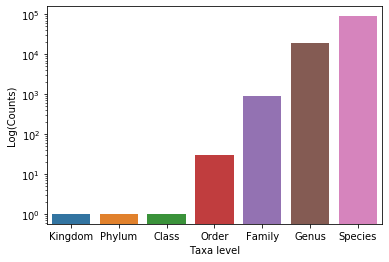

In [1]:
import pandas as pd
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

def get_taxa(line):
    bl = line.strip().split()
    return '_'.join(bl[1:])

taxlevels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
with open('ISIS_realized.reference.fasta') as ref:
    headers = '\n'.join([get_taxa(line) for line in ref if line.startswith('>')])
df = pd.read_csv(StringIO(headers), sep=';', header=None, names=taxlevels)
nu = df.nunique().reset_index()
nu.columns = ['Taxa level','Counts']
print('Figure S1. Distribution of taxonomic levels in the insecta reference dataset')
ax = sns.barplot(x='Taxa level', y='Counts', data=nu)
ax.set_yscale("log")
t = ax.set_ylabel('Log(Counts)')

In [2]:
import qgrid
print('Table S1. Interactive table showing the diversity of the insecta reference dataset')
qgrid_widget = qgrid.show_grid(df.reindex(columns=['Order', 'Family', 'Genus', 'Species']), show_toolbar=True)
qgrid_widget 

Table S1. Interactive table showing the diversity of the insecta reference dataset


qgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

The resulting reference fasta file contained 552314 COI sequences of various lengths (Table S2). It is important to not that not all sequences in this reference contained the MLepF1/LepR1 fragment, but all contained all or partial COI sequences.

In [3]:
print('Table S2. Sequence statistics of the insecta reference dataset')
!seqkit stats ISIS_realized.reference.fasta

Table S2. Sequence statistics of the insecta reference dataset
file                           format  type  num_seqs      sum_len  min_len  avg_len     max_len
ISIS_realized.reference.fasta  FASTA   DNA    552,314  656,595,150      200  1,188.8  28,180,402


### 1.2 Anchors

$A2G^2$ requires a global anchor (i.e. full genic region) and a local anchor (i.e. amplicon region). For the former, we took the Midori (Leray, et al. 2018) COI dataset and generated a consensus sequence to act as the global COI anchor. For the local anchor, we created a consensus sequences based on the amplicons in the Braukmann et al. (2019) mock community.

### 1.3 System
All computation (otherwise stated) were performed in a Dell XPS13 laptop, with 16Gb of RAM, processor Intel® Core™ i7-10710U CPU @ 1.10GHz × 12, graphic Intel® UHD Graphics (Comet Lake 3x8 GT2). We chose to have a commercial laptop for the benchmarking to impose computational constraints that are usual in biology.

### 1.4 Measures of goodness
Given that the main goal of the main manuscript is to lower the amount of extraneous gaps in sequence alignment, and given that the fragment in question should not include too many gaps (COI, MLepF1/LepR1 amplicon), we will show the Average fraction of gaps per sequence (AFGS) as accuracy metric. Let's cal $\tau$ to the total number of gaps in the alignment, $\lambda$ the total alignment length after trimming, and $n$ the number of sequences, the $AFGS$ can be computed as:

\begin{equation*}
AFGS = \frac{\tau}{\lambda * n}
\end{equation*}

## 2.0 Benchmark
There are two parts of this benchmark. We start by testing the accuracy (defined by AFGS) of  MAFFT alignment (traditional), PASTA, and $A2G^2$. In this case we want to test the scalability, feasibility, and AFGS in each strategy. We test MAAFT as the traditional aligner since is the one used in the $A2G^2$ algorithm and is one of the most use multiple sequence aligners (MSA) to date.
Then, we move $A2G^2$'s scalabity with the number of cpus used. For this test we will use a computer cluster in Compute Canada (Graham supercomputer, SHARCNET), that will allow us to test from single thread up to 32 threads without MPI.

### 2.1 Comparison of MAFFT alignment (traditional), PASTA and $A2G^2$
For this case we will try to align subsets of increasing size of the Insecta reference dataset until the full dataset is consumed. We will measure both time, completion and number of gaps in each iteration. To have a fair comparison in the number of gaps generated, we will remove gap-only sites, and sites where more than 90% of sites are gaps from the MAFFT alignment. We will also compare the full output (no outlier detection and removal) of $A2G^2$, however, for downstream analyses in this supplementary note, the time includes the outlier detection and removal.

In [4]:
import time
import dill
import textwrap
import numpy as np
from os.path import isfile, basename
from subprocess import Popen, PIPE
import tempfile
from IPython.core.debugger import set_trace
from psutil import Process
from os import getpid
from os.path import splitext, split

process = Process(getpid())


def aln2pa(fasta, **kwargs):
    if isinstance(fasta, bytes):
        fasta = fasta.decode('utf-8')
    if len(kwargs) == 2:#fasta.startswith('>'):
#         kwargs['jobname'] = 'pastajob'
#         kwargs['filename'] = split(splitext(kwargs['filename'])[0])[-1]
        fn = fasta.split('\n')[-4].split()[-1].strip('"')
        with open(fn) as inf:
            #set_trace()
            fasta = inf.read()
    
    bl = fasta.strip()[1:].split('\n>')
    d = {k.split('\n')[0]: list(''.join(k.split('\n')[1:])) for k in bl}
    df = pd.DataFrame.from_dict(d, orient='index')
    nseq = df.shape[0]
    max_gaps = int(0.99 * nseq)
    df = df.loc[:,~df.eq("-").sum().gt(max_gaps)]
    n_gaps = df.eq('-').sum().sum()
    lenght = df.shape[1]
    fa = '\n'.join([">{name}\n{seq}".format(name=x[0],seq=textwrap.fill(
        ''.join(x[1:]), width=70)) for x in df.itertuples()])
    return fa, n_gaps, lenght 

def run_n_trim(command, **kwargs):
    #set_trace()
    args = command.format(**kwargs)
    print('Processing', args)
    args = args.split()
    ct = time.time()
    cm = process.memory_info().rss
    st = Popen(args, stdout=PIPE, stderr=PIPE)
    o, e = st.communicate()
    #set_trace()
    fn = basename(filename)
    with open('aln_%s'%fn, 'w') as d:
        d.write(o.decode('utf-8'))
    if e != '':
        elapsed = time.time() - ct
        me_used = (process.memory_info().rss - cm) * 1e-6
        trimmed, ngaps, lenght = aln2pa(o, **kwargs)
    else:
        elapsed = np.nan
        trimmed = np.nan
        ngaps = np.nan
        lenght = np.nan
    return trimmed, elapsed, me_used, ngaps, lenght

if isfile('bench_result.dill'):
    n_df = pd.read_csv('Results.tsv', sep='\t')
    n_df['Average gaps per sequence'] = n_df['Total gaps'] / n_df['Number of sequences']
    n_df['Average fraction of gaps per sequence'] = n_df['Total gaps'] / (n_df['Alignment lenght'] * n_df['Number of sequences'])
    n_df['Average gaps per sequence'] = n_df['Total gaps'] / n_df['Number of sequences']
    #n_df['Time elapsed (hours)'] = n_df['Time elapsed'] / 60**2
    miss = (~np.isnan(n_df['Average fraction of gaps per sequence'])).astype(int)
    n_df['Time elapsed (hours)'] = n_df['Time elapsed'] / (60**2 * miss)
    n_df['Time elapsed (mins)'] = n_df['Time elapsed'] / (60 * miss)
else:
    space =  [1500, 10000, 30000, 60000, 100000, 300000, 557314] #np.logspace(2, np.log10(df.shape[0]), endpoint=True, num=10, dtype=int)
    n_df = pd.DataFrame()
    if isfile('Results.tsv'):
        n_df = pd.read_csv('Results.tsv', sep='\t', index_col=0)
        space = list(set(space).difference(n_df['Number of sequences'].unique()))
    seqkit = 'seqkit -j 12 head -n {fraction} {filename}'
    mafft = 'mafft --thread -1 {filename}'
    a2g = 'A2G midori50.consensus Mlep_consensus.fst {filename} --cpus -1 --no_write'
    pasta = 'run_pasta.py -i {filename} --alignment-suffix={fraction}'
    filename = 'ISIS_realized.reference.fasta'
    results = []
    for fraction in space:
        print('Aligning', fraction, 'sequences')
        sk = seqkit.format(fraction=fraction, filename=filename).split()
        frac = Popen(sk, stdout=PIPE, stderr=PIPE)
        o, e = frac.communicate()
        with tempfile.TemporaryDirectory() as tmpdirname:
            with tempfile.NamedTemporaryFile(dir=tmpdirname, delete=False) as tfile:
                tfile.write(o)
            m_aln, m_time, m_mem, m_ngaps, m_lenght = run_n_trim(mafft, filename=tfile.name)
            results.append({'Strategy': 'MAFFT', 'Number of sequences': fraction, 
                           'Time elapsed': m_time, 'Memory used': m_mem,
                           'Total gaps': m_ngaps, 'Alignment lenght': m_lenght})
            print(results)
            a_aln, a_time, a_mem, a_ngaps, a_lenght = run_n_trim(a2g, filename=tfile.name)
            results.append({'Strategy': r'$A2G^2$', 'Number of sequences': fraction, 
                           'Time elapsed': a_time, 'Memory used': m_mem,
                           'Total gaps': a_ngaps, 'Alignment lenght': a_lenght})
            print(results)
            p_aln, p_time, p_mem, p_ngaps, p_lenght = run_n_trim(pasta, filename=tfile.name, 
                                                                 fraction=fraction)
            results.append({'Strategy': 'PASTA', 'Number of sequences': fraction, 
                           'Time elapsed': p_time, 'Memory used': p_mem,
                           'Total gaps': p_ngaps, 'Alignment lenght': p_lenght})
            print(results)
            n_df = n_df.append(results)
            n_df.to_csv('Results.tsv', sep='\t')
            #set_trace()
    with open('bench_result.dill', 'wb') as sh:
        dill.dump(results, sh)
    n_df = pd.read_csv('Results.tsv', sep='\t')
    n_df['Average fraction of gaps per sequence'] = n_df['Total gaps'] / (n_df['Alignment lenght'] * n_df['Number of sequences'])
    n_df['Average gaps per sequence'] = n_df['Total gaps'] / n_df['Number of sequences']
    miss = (~np.isnan(n_df['Average fraction of gaps per sequence'])).astype(int)
    n_df['Time elapsed (hours)'] = n_df['Time elapsed'] / (60**2 * miss)
    n_df['Time elapsed (mins)'] = n_df['Time elapsed'] / (60 * miss)

n_df = n_df.replace(np.inf, np.nan)

Figure S2. Time and AFGS as a function of the number of sequences in MAFFT, PASTA and our method. A. Average gaps per sequence, and B. Time elapsed in minutes


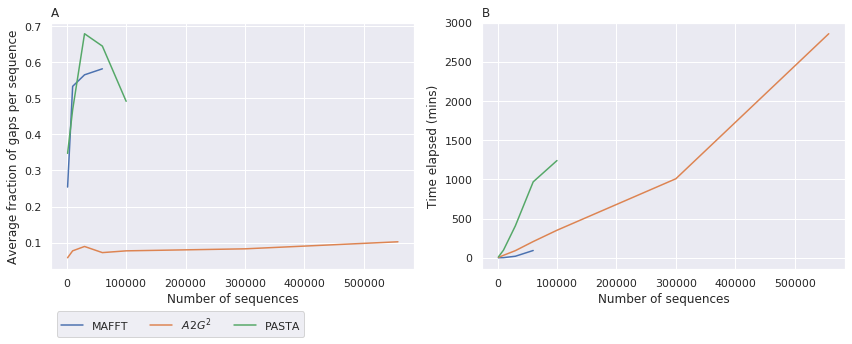

In [6]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
print('Figure S2. Time and AFGS as a function of the number of sequences in MAFFT, PASTA and our method. '
      'A. Average gaps per sequence, and B. Time elapsed in minutes')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title('A', fontdict=None, loc='left', pad=None)
ax2.set_title('B', fontdict=None, loc='left', pad=None)
g = sns.lineplot(x="Number of sequences", y="Average fraction of gaps per sequence", hue="Strategy", data=n_df, ax=ax1)
sns.lineplot(x="Number of sequences", y="Time elapsed (mins)", hue="Strategy", data=n_df, ax=ax2, legend=False)
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles[1:], labels=labels[1:], loc='upper left', bbox_to_anchor=(0, -0.15), ncol=3)
plt.tight_layout()
plt.show()

We show that MAFFT and PASTA fail to align more than 100000 sequences (Figure S2) with the setting and computing system (laptop) provided. The main reason for this is lack of memory on the laptop we tested the alignments in. We can see, however, that $A2G^2$ can effectively finish all 552314 and on linear time with respect to the number of sequences Figure S2B). This makes $A2G^2$ very scalable with the addition of more processing cores. Further more, we show that the average number of gaps per sequence is constant regardless of the sequences being analyzed (Figure S2A). This occurs because $A2G^2$ keeps the aligned region constant (407bp) and if the query sequence being aligned is not part of the local region (MLepF1/LepR1 amplicon), only up to 407 gaps will be assigned, while MAFFT includes all gaps from the misalignment between the query, the global and local regions. We believe this is the same case for PASTA, since their algorithm optimizes for tree stability regardless of gap inclusion (Mirarab et al. 2015) . We also have shown that $A2G^2$ introduces fewer gaps than MAFFT, produces the alignment on the intended region and it can align an arbitrary number of sequences in a commercial laptop, provided enough time (~47 hours for 552314 sequences).

### 2.2 Scalability of  $A2G^2$
For this case we aligned a subset of 100k sequences from the Insecta reference dataset. The alignment was performed using a range from 1 to 31 CPUs in a computer cluster node (Figure S3).


Figure S3. Scalability of our method on 100k sequences in using a range of CPUs


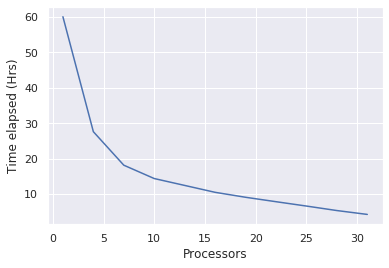

In [8]:
sc = pd.read_csv('a2g_scalability.tsv', sep='\t')
sc['Time elapsed (Hrs)'] = sc['Time elapsed'] / 60 / 60
print('Figure S3. Scalability of our method on 100k sequences in using a range of CPUs')
ax = sns.lineplot(x="Processors", y="Time elapsed (Hrs)", data=sc)

In this section we showed that $A2G^2$ has an exponential decay with the number of cores. This means our algorithm greatly benefits from higher performance computers with a large number of cores (Figure S3). It is important to point out that large RAM memory is not required, but instead processing power. Another advantage of our implementation is that separate runs with the same anchors will render global alignments in the region of the local anchor. This means that you can easily partition your dataset into chunks and submit them independently to different computers, making it usable in a HPC environment. Despite we provide an MPI implementation of the algorithm, it is more efficient for the scheduler in supercomputers to submit separate jobs or job arrays rather than using MPI. MPI has a significant overhead and the processes do not require sharing data across runs, therefore making it more efficient to run each process separately and concatenating the resulting file.

## References

1. Braukmann,T.W.A. et al. (2019) Metabarcoding a diverse arthropod mock community. Mol. Ecol. Resour., 19, 711–727.

2. Hebert,P.D.N. et al. (2004) Ten species in one: DNA barcoding reveals cryptic species in the neotropical skipper butterfly Astraptes fulgerator. Proc Natl Acad Sci USA, 101, 14812–14817.

3. Leray,M. et al. (2018) MIDORI server: a webserver for taxonomic assignment of unknown metazoan mitochondrial-encoded sequences using a curated database. Bioinformatics, 34, 3753–3754.

4. Mirarab, S., Nguyen, N., Guo, S., Wang, L. S., Kim, J., & Warnow, T. (2015). PASTA: ultra-large multiple sequence alignment for nucleotide and amino-acid sequences. Journal of Computational Biology, 22(5), 377-386.
